In [17]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import csv
import time
import itertools
import seaborn as sns

import nltk
import nltk.corpus # sample text for performing tokenization
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec
from gensim.parsing.porter import PorterStemmer
from gensim.utils import simple_preprocess

# Train the random forest and optimize it
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.model_selection import cross_val_score


In [33]:
missing_values = ["n/a", "na", "--", "NaN"]

# Load from the filename
X_train = pd.read_csv('data/train_w2v.csv')
X_test = pd.read_csv('data/test_w2v.csv')

y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/y_test.csv')


In [34]:
le = LabelEncoder()
y_train = le.fit_transform(y_train['oh_label'])
y_test = le.fit_transform(y_test['oh_label'])

In [22]:
xgb_word2vec = xgb.XGBClassifier(objective='multi:softmax', random_state=42, booster='gbtree',
                                 eval_metric='aucpr',num_class=2)

params = dict(n_estimators=randint(50,300),
              max_depth=randint(1,6), # default 3
              colsample_bytree= uniform(0.7, 0.3), # default 1
              alpha= uniform(0.3, 0.9),
              gamma= uniform(0, 0.5), # default 0
              learning_rate= uniform(0.03, 0.3), # default 0.1 
              subsample= uniform(0.6, 0.4))
xgb_word2vec = RandomizedSearchCV(xgb_word2vec, params, random_state=0, scoring='f1', verbose=1, 
                                  n_jobs=1, return_train_score=True)
xgb_word2vec.fit(X_train, y_train)

optimal_model = xgb_word2vec.best_estimator_
optimal_model

Fitting 5 folds for each of 10 candidates, totalling 50 fits


XGBClassifier(alpha=0.45381862662244066, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8074456500908574, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.3753430706092281, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.21234920061464033, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=171, n_jobs=None, num_class=2,
              num_parallel_tree=None, ...)

In [41]:
xgy_pred_train = xgb_word2vec.predict(X_train)
xgy_pred = xgb_word2vec.predict(X_test)

print(f"XGBoost train accuracy: {xgb_word2vec.score(X_train, y_train):.3f}")
print(f"XGBoost test accuracy: {xgb_word2vec.score(X_test, y_test):.3f}")

print(f"XGBoost train f1 score: {metrics.f1_score(y_train, xgy_pred_train):.3f}")
print(f"XGBoost test f1 score: {metrics.f1_score(y_test, xgy_pred):.3f}")

XGBoost train accuracy: 0.835
XGBoost test accuracy: 0.784
XGBoost train f1 score: 0.835
XGBoost test f1 score: 0.784


In [42]:
print(classification_report(y_train,xgy_pred_train))

print(classification_report(y_test,xgy_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96    146309
           1       0.88      0.79      0.83     36779

    accuracy                           0.94    183088
   macro avg       0.91      0.88      0.90    183088
weighted avg       0.94      0.94      0.94    183088

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     48770
           1       0.83      0.75      0.78     12260

    accuracy                           0.92     61030
   macro avg       0.88      0.85      0.87     61030
weighted avg       0.92      0.92      0.92     61030



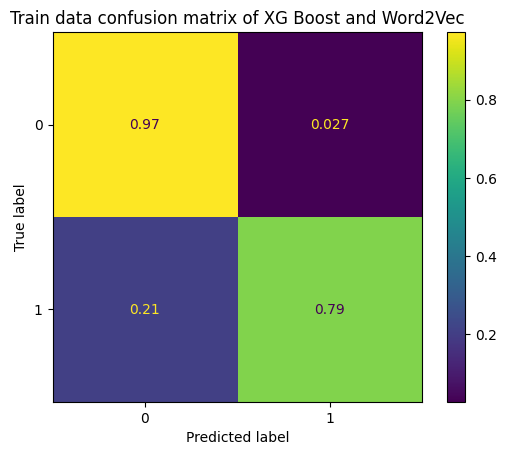

In [45]:
cm = confusion_matrix(y_train, xgy_pred_train, labels=xgb_word2vec.classes_,normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=xgb_word2vec.classes_)
disp.plot()

plt.title("Train data confusion matrix of XG Boost and Word2Vec")
plt.show()

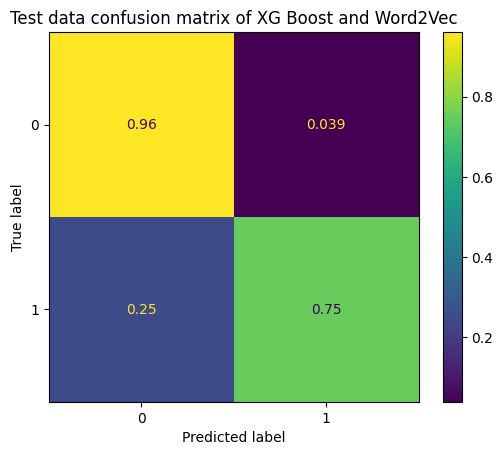

In [46]:
cm = confusion_matrix(y_test, xgy_pred, labels=xgb_word2vec.classes_,normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=xgb_word2vec.classes_)
disp.plot()

plt.title("Test data confusion matrix of XG Boost and Word2Vec")
plt.show()

In [47]:
# View confusion matrix for test data and predictions
print(confusion_matrix(y_train, xgy_pred_train))
print(confusion_matrix(y_test, xgy_pred))

[[142291   4018]
 [  7566  29213]]
[[46845  1925]
 [ 3121  9139]]


### Compare with TF-IDF Vectorizer

In [48]:
# Load from the filename
X_train = pd.read_csv('data/X_train_tfidf.csv')
y_train = pd.read_csv('data/y_train_tfidf.csv')

In [49]:
le = LabelEncoder()
y_train = le.fit_transform(y_train['oh_label'])

In [30]:
xgb_tfidf = xgb.XGBClassifier(objective='multi:softmax', random_state=42, booster='gbtree',
                              eval_metric='aucpr',num_class=2)

params = dict(n_estimators=randint(50,300),
              max_depth=randint(1,6), # default 3
              colsample_bytree= uniform(0.7, 0.3), # default 1
              alpha= uniform(0.3, 0.9),
              gamma= uniform(0, 0.5), # default 0
              learning_rate= uniform(0.03, 0.3), # default 0.1 
              subsample= uniform(0.6, 0.4))
xgb_tfidf = RandomizedSearchCV(xgb_tfidf, params, random_state=0, scoring='f1', verbose=1, 
                               n_jobs=1, return_train_score=True)
xgb_tfidf.fit(X_train, y_train)

optimal_model = xgb_tfidf.best_estimator_
optimal_model

Fitting 5 folds for each of 10 candidates, totalling 50 fits


XGBClassifier(alpha=0.45381862662244066, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8074456500908574, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.3753430706092281, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.21234920061464033, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=171, n_jobs=None, num_class=2,
              num_parallel_tree=None, ...)

In [51]:
tfidf_xgy_pred_train = xgb_tfidf.predict(X_train)

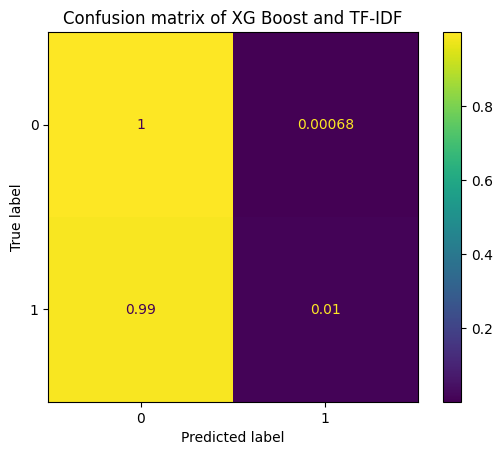

In [52]:
cm = confusion_matrix(y_train, tfidf_xgy_pred_train, labels=xgb_tfidf.classes_,normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=xgb_tfidf.classes_)
disp.plot()
plt.title("Confusion matrix of XG Boost and TF-IDF")
plt.show()

In [32]:
# Look at result
xgy_pred_train = xgb_tfidf.predict(X_train)

# View confusion matrix for test data and predictions
print(confusion_matrix(y_train, xgy_pred_train))
print(classification_report(y_train,xgy_pred_train))


[[146210     99]
 [ 36405    374]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89    146309
           1       0.79      0.01      0.02     36779

    accuracy                           0.80    183088
   macro avg       0.80      0.50      0.45    183088
weighted avg       0.80      0.80      0.71    183088

